In [ ]:
!pip install yfinance mplfinance matplotlib

In [1]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
# for Japanese Candles analysis
import matplotlib.dates as mdates
# for Elliot Wave analysis
from scipy.signal import find_peaks

In [2]:
def download_stock_data(symbol, start, end):
    """
    Download stock data from yfinance.
    """
    data = yf.download(symbol, start=start, end=end)
    return data

def calculate_ema(data, period, column='Close'):
    """
    Calculate Exponential Moving Average (EMA) for a given period.
    """
    return data[column].ewm(span=period, adjust=False).mean()

def identify_support_levels(data, window=20):
    """
    Identify potential support levels based on recent lows within a specified window.
    """
    # Find the minimum close price within the specified window
    recent_lows = data['Close'].rolling(window=window).min()
    support_levels = recent_lows[-window:].dropna().unique()  # Get unique recent low prices as support levels
    return support_levels
# candles analysis
def candle_ema_analysis(data, short_period_1=144, short_period_2=169, long_period=576):
    """
    Calculate the exponential moving averages (EMAs) for the Vegas channel analysis.
    """
    data['EMA_144'] = calculate_ema(data, 144)
    #data['EMA_144'] = data['Close'].ewm(span=short_period_1, adjust=False).mean()
    data['EMA_169'] = calculate_ema(data, 169)
    #data['EMA_169'] = data['Close'].ewm(span=short_period_2, adjust=False).mean()
    data['EMA_576'] = calculate_ema(data, 576)
    #data['EMA_576'] = data['Close'].ewm(span=long_period, adjust=False).mean()
    return data
# MCA vegas analysis
def vegas_channel_analysis(data):
    """
    Perform Vegas Channel Analysis by calculating the necessary EMAs.
    """
    # Calculate EMAs for the Vegas Tunnel (144 and 169 periods)
    data['EMA_144'] = calculate_ema(data, 144)
    data['EMA_169'] = calculate_ema(data, 169)
    
    # Calculate shorter-term EMAs (12 and 24 periods)
    data['EMA_12'] = calculate_ema(data, 12)
    data['EMA_24'] = calculate_ema(data, 24)
    
    return data
# for Japanese Candles
#def identify_support_levels(data, window=20):
#    """
#    Identify potential support levels based on recent lows within a specified window.
#    """
#    recent_lows = data['Close'].rolling(window=window).min()
#    support_levels = recent_lows[-window:].dropna().unique()
#    return support_levels
# for elliot waves analysis
def identify_peaks_and_troughs(prices, distance=5):
    """
    Identify local peaks and troughs in price data.
    
    Parameters:
    - prices (pd.Series): The price data to analyze (e.g., close prices).
    - distance (int): Minimum number of points between peaks or troughs.
    
    Returns:
    - peaks (list): Indices of local maxima.
    - troughs (list): Indices of local minima.
    """
    # Find peaks (local maxima)
    peaks, _ = find_peaks(prices, distance=distance)
    
    # Find troughs (local minima)
    troughs, _ = find_peaks(-prices, distance=distance)
    
    return peaks, troughs

In [3]:
def plot_vegas_channel(data, symbol):
    """
    Plot the stock's closing prices along with the Vegas Tunnel (144 and 169 EMAs) and shorter-term EMAs.
    """
    # Info about stock
    stock = yf.Ticker(symbol)
    info = stock.info
    try:
        sector = info['sector'] or "Undef"
    except KeyError:
        sector = "ETF"
    latest_close = data['Close'].iloc[-1]
    latest_date = data.index[-1]
    # Identify support levels
    support_levels = identify_support_levels(data)
    
    # create subplots so I can see volume of stocks
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10), sharex=True, gridspec_kw={'height_ratios': [3,1]})
    #plt.figure(figsize=(14, 8))
    
    # Plot the closing prices
    # plt.plot(data['Close'], label='Close Price', color='blue', alpha=0.5)
    ax1.plot(data['Close'], label='Close Price', color='blue', alpha=0.5)
    
    # Plot the Vegas Tunnel (EMA 144 and EMA 169)
    # plt.plot(data['EMA_144'], label='EMA 144', color='green', linestyle='--')
    ax1.plot(data['EMA_144'], label='EMA 144', color='green', linestyle='--')
    # plt.plot(data['EMA_169'], label='EMA 169', color='red', linestyle='--')
    ax1.plot(data['EMA_169'], label='EMA 169', color='red', linestyle='--')
    
    # Plot the shorter-term EMAs (EMA 12 and EMA 24)
    # plt.plot(data['EMA_12'], label='EMA 12', color='purple')
    ax1.plot(data['EMA_12'], label='EMA 12', color='purple')
    # plt.plot(data['EMA_24'], label='EMA 24', color='orange')
    ax1.plot(data['EMA_24'], label='EMA 24', color='orange')
    
    # Hightlight latest close price
    # plt.scatter(latest_date, latest_close, color='black', zorder=5, label=f"Latests Close: {latest_close:.2f}")
    ax1.scatter(latest_date, latest_close, color='black', zorder=5, label=f"Latests Close: {latest_close:.2f}")
    # plt.axhline(latest_close, color='black', linestyle=':', alpha=0.7)
    ax1.axhline(latest_close, color='black', linestyle=':', alpha=0.7)
    
    # Plot support levels
    for level in support_levels:
        ax1.axhline(level, color='purple', linestyle='--', alpha=0.5, label=f'Support Level: {level:.2f}')

    # Customize the plot
    # plt.title(f'Vegas Channel Analysis for {symbol}')
    ax1.set_title(f'{latest_date}-Vegas Channel Analysis for {symbol}-{sector}')
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    ax1.set_ylabel('Price')
    # plt.legend()
    ax1.legend(loc='best')
    # plt.grid(True)
    ax1.grid(True)
    
    # Plot volume on ax2
    ax2.bar(data.index, data['Volume'], fill='lightblue', color='red', alpha=0.7)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Date')
    ax2.grid(True)
    
    # adjust layout
    plt.tight_layout()
    plt.show()

In [4]:
def plot_candlestick_with_vegas_and_support(data, symbol):
    """
    Plot candlesticks, Vegas channels, support levels, and volume.
    """
    # Prepare figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    
    # Convert date index to numeric x-coordinates for consistent plotting
    data['Date_num'] = mdates.date2num(data.index)  # Convert datetime index to numeric
    x_coords = data['Date_num']
    # Format date for x-axis
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()


    # Plot candlesticks
    for i in range(len(data)):
        open_price = data['Open'][i]
        close_price = data['Close'][i]
        high_price = data['High'][i]
        low_price = data['Low'][i]
        
        # Color settings for up (green) and down (red) candles
        color = 'green' if close_price >= open_price else 'red'
        
        # Draw the candle's body
        #ax1.add_patch(plt.Rectangle((i - 0.2, min(open_price, close_price)),
        #                            0.4, abs(close_price - open_price),
        #                            color=color, alpha=0.6))
        ax1.add_patch(plt.Rectangle((x_coords[i] - 0.2, min(open_price, close_price)),0.4, abs(close_price - open_price),color=color, alpha=0.6))
        
        # Draw the candle's wick
        #ax1.plot([i, i], [low_price, high_price], color=color, linewidth=0.8)
        ax1.plot([x_coords[i], x_coords[i]], [low_price, high_price], color=color, linewidth=0.8)

    # Plot the Vegas channels
    ax1.plot(data.index, data['EMA_144'], label='EMA 144', color='green', linestyle='--')
    ax1.plot(data.index, data['EMA_169'], label='EMA 169', color='orange', linestyle='--')
    ax1.plot(data.index, data['EMA_576'], label='EMA 576', color='red', linestyle='--')

    # Highlight latest close price
    latest_close = data['Close'].iloc[-1]
    latest_date = data.index[-1]
    ax1.scatter(latest_date, latest_close, color='black', zorder=5, label=f'Latest Close: {latest_close:.2f}')
    ax1.axhline(latest_close, color='black', linestyle=':', alpha=0.7)

    # Plot support levels
#    support_levels = identify_support_levels(data)
#    for level in support_levels:
#        ax1.axhline(level, color='purple', linestyle='--', alpha=0.5, label=f'Support Level: {level:.2f}')

    # Labels and legend for ax1 (price chart)
    ax1.set_title(f"Candlestick Chart with Vegas Channels and Support Levels for {symbol}")
    ax1.set_ylabel('Price')
    ax1.legend(loc='best')
    ax1.grid(True)

    # Plot volume on ax2
    ax2.bar(data.index, data['Volume'], color='gray', alpha=0.7)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Date')
    ax2.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [5]:
def plot_elliott_wave(prices, peaks, troughs, title="Elliott Wave Analysis"):
    """
    Plot the price data with detected Elliott wave points (peaks and troughs).
    
    Parameters:
    - prices (pd.Series): The price data to plot.
    - peaks (list): Indices of local maxima.
    - troughs (list): Indices of local minima.
    - title (str): Title of the chart.
    """
    plt.figure(figsize=(14, 8))
    plt.plot(prices, label='Stock Price', color='blue', alpha=0.7)
    
    # Highlight peaks and troughs
    #plt.scatter(peaks, prices[peaks], color='green', label='Peaks (Wave Highs)', marker='o')
    #plt.scatter(troughs, prices[troughs], color='red', label='Troughs (Wave Lows)', marker='o')
    
    plt.scatter(prices.index[peaks], prices.iloc[peaks], color='green', label='Peaks (Wave Highs)', marker='o')
    plt.scatter(prices.index[troughs], prices.iloc[troughs], color='red', label='Troughs (Wave Lows)', marker='o')
    
    # Connect wave points
    wave_points = sorted(list(peaks) + list(troughs))
    #plt.plot(wave_points, prices[wave_points], color='orange', linestyle='--', label='Elliott Wave')
    plt.plot(prices.index[wave_points], prices.iloc[wave_points], color='orange', linestyle='--', label='Elliott Wave')
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

[*********************100%%**********************]  1 of 1 completed


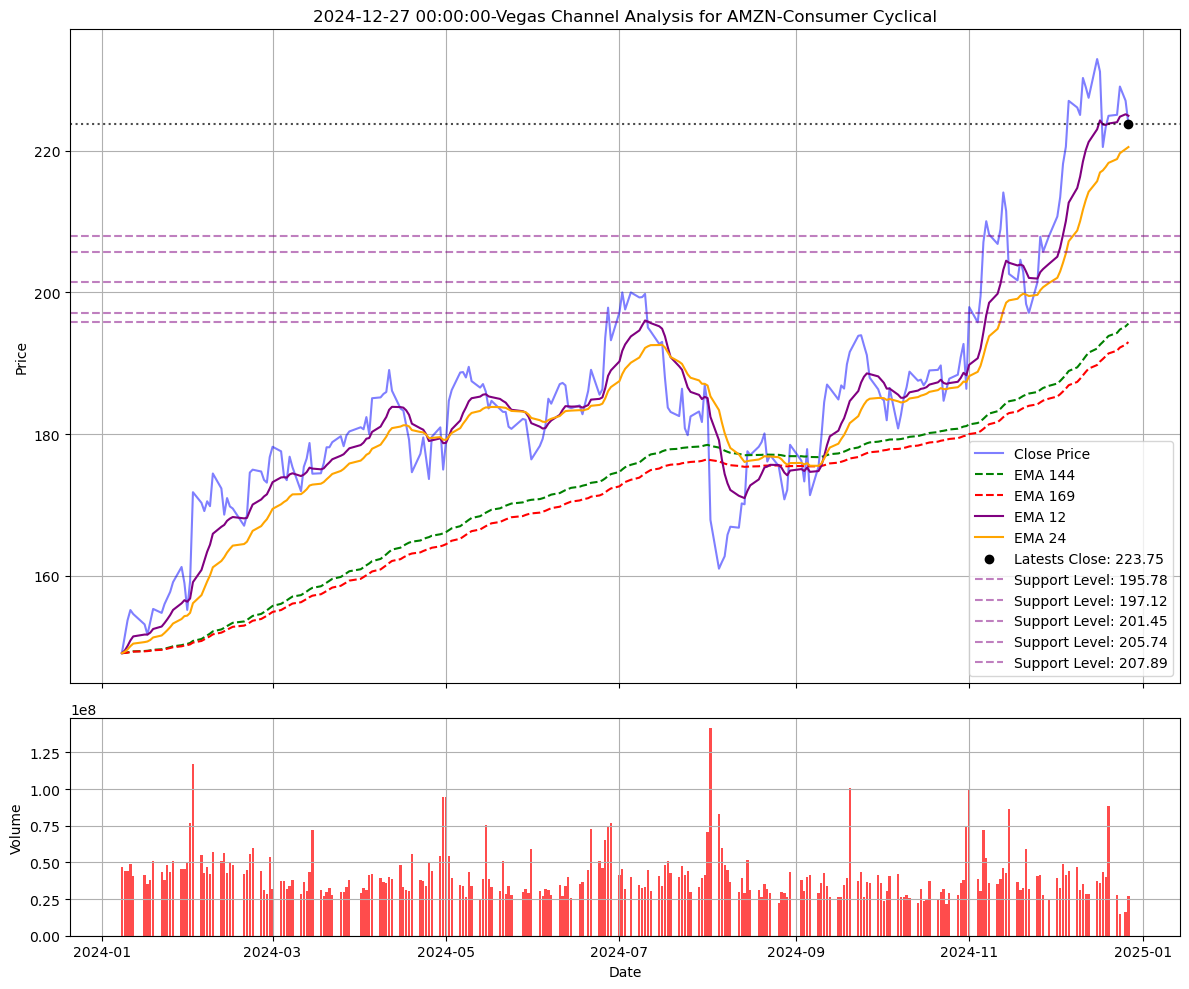

In [7]:
# Stock symbol and date range
symbol = 'AMZN'  # Example: Apple stock
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


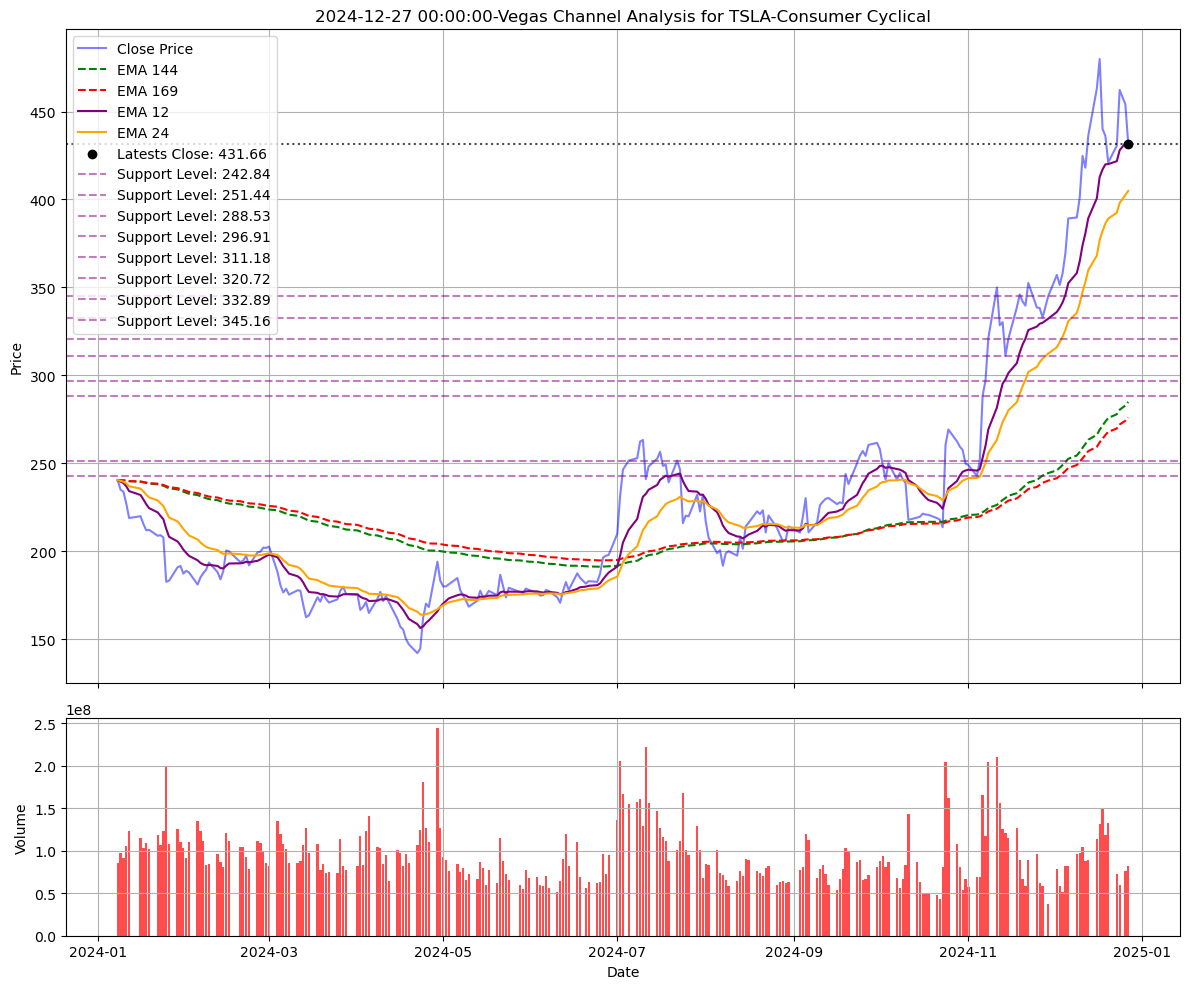

In [8]:
# Stock symbol and date range
symbol = 'TSLA'  # Tesla
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


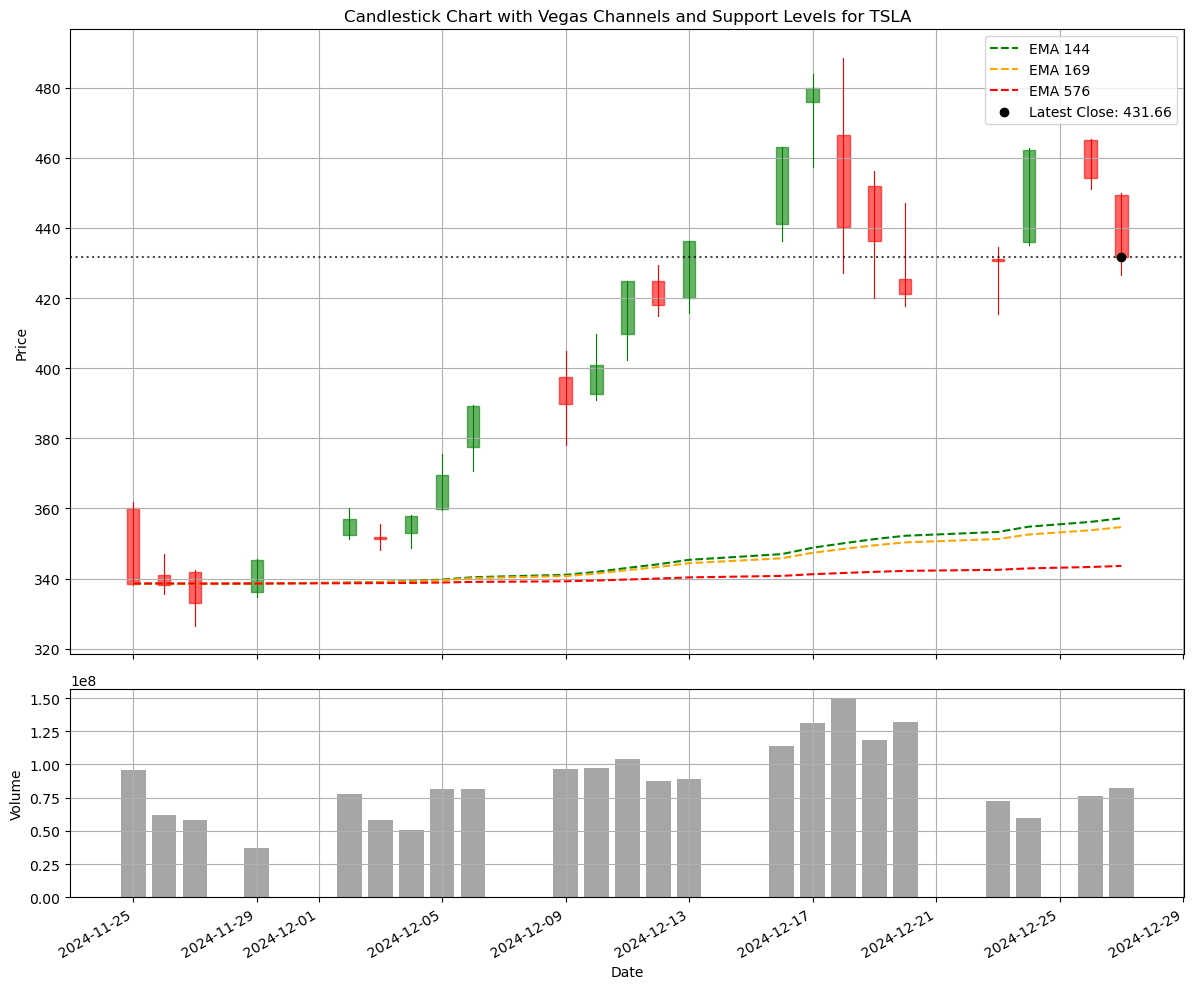

In [9]:
# Stock symbol and date range with Japanese Candles analysis
symbol = 'TSLA'  # TESLA
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 5
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-11-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)
#stock_data
# Perform Japanese Candle Analysis (calculate EMAs)
stock_data = candle_ema_analysis(stock_data)

# Plot the result
plot_candlestick_with_vegas_and_support(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


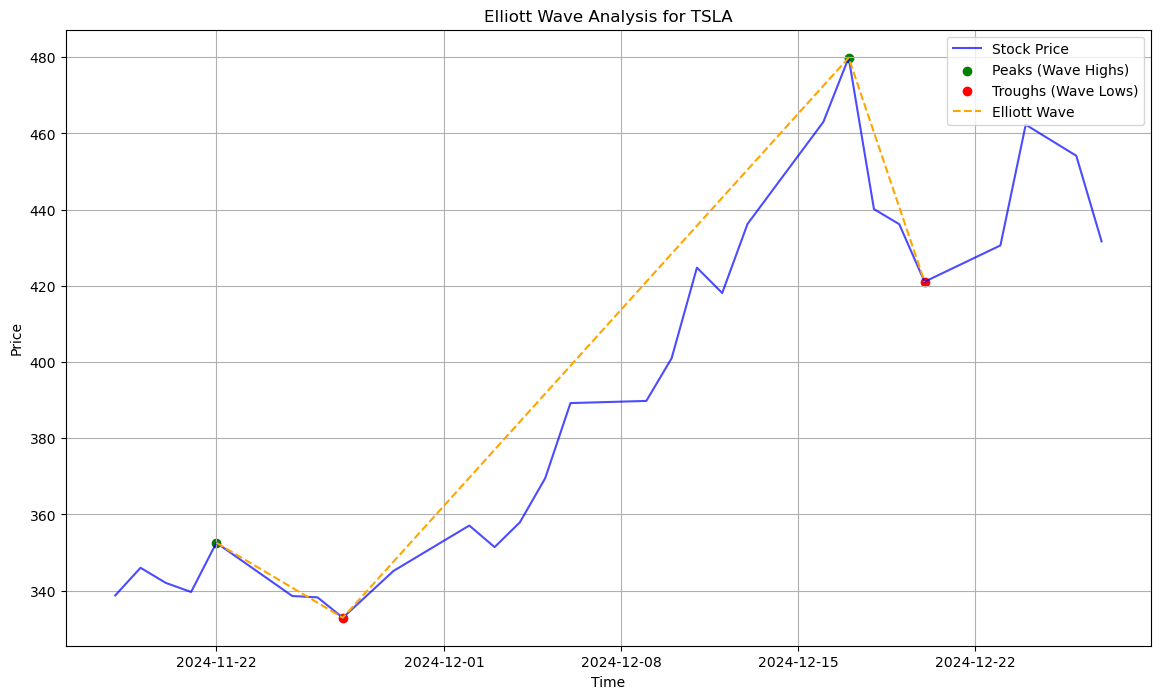

In [10]:
# Stock symbol and date range with Elliot Wave analysis
symbol = 'TSLA'  # TESLA
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 6
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-11-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Step 1: Download the stock data
elliot_stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Step 2: Identify peaks and troughs
elliot_close_prices = elliot_stock_data['Close']
# test
#elliot_close_prices.plot()

distance = 15
peaks, troughs = identify_peaks_and_troughs(elliot_close_prices, distance=distance)

# Step 3: Plot the Elliott wave analysis
plot_elliott_wave(elliot_close_prices, peaks, troughs, title=f"Elliott Wave Analysis for {symbol}")
plt.close()

[*********************100%%**********************]  1 of 1 completed


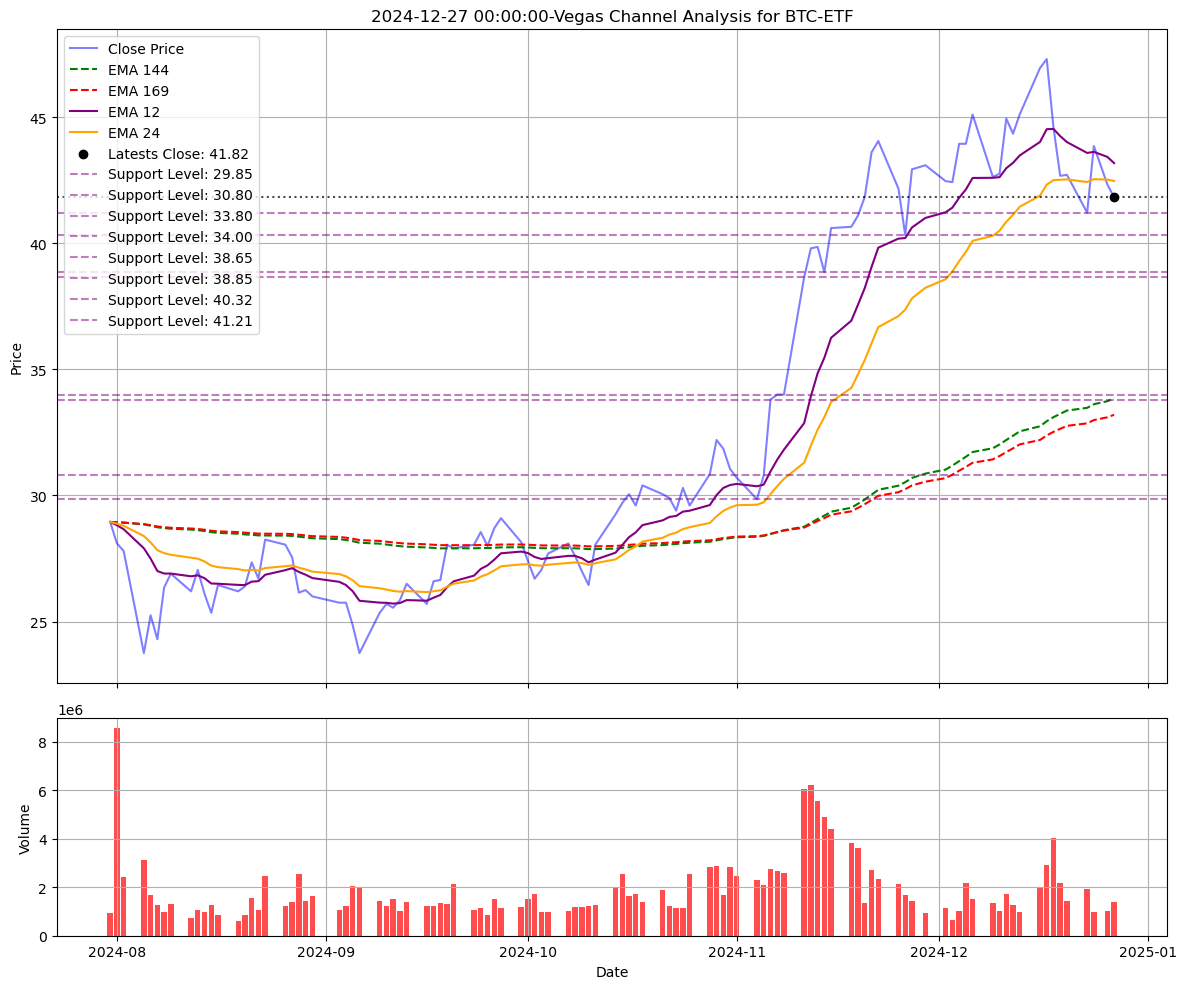

In [11]:
# Stock symbol and date range
symbol = 'BTC'  # Bitcoin
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


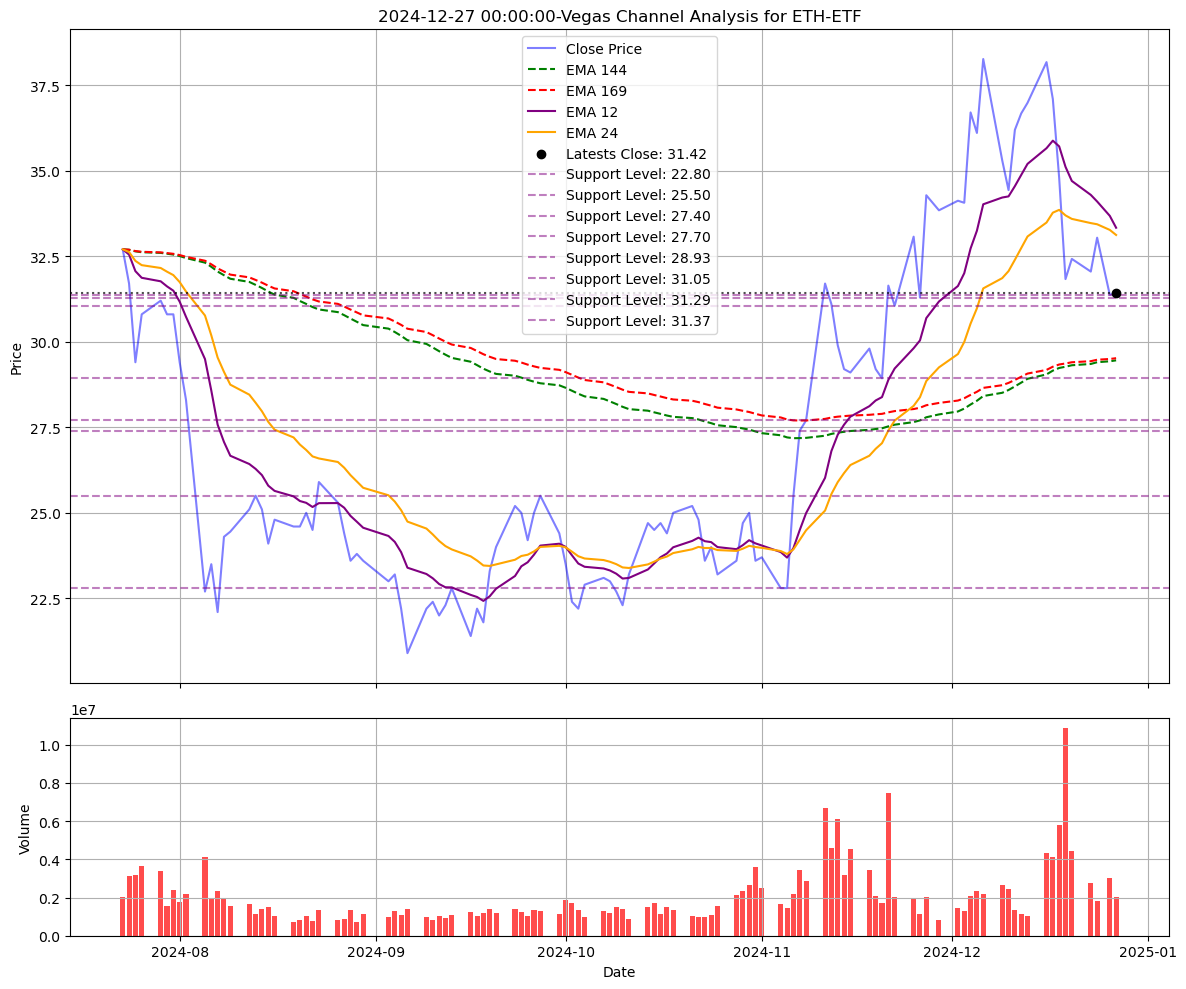

In [12]:
# Stock symbol and date range
symbol = 'ETH'  # Ethereum
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


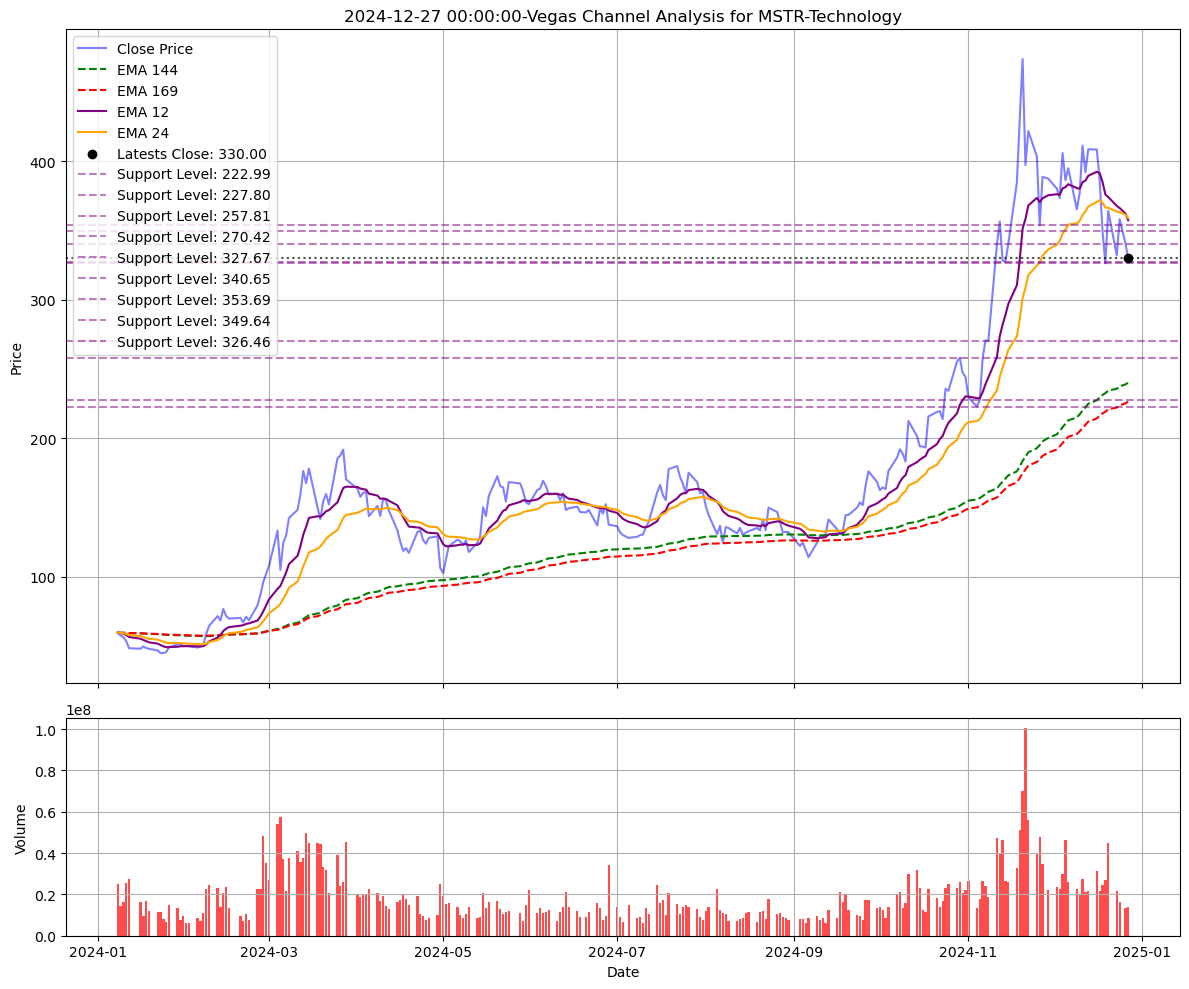

In [13]:
# Stock symbol and date range
symbol = 'MSTR'  # Microstrategy
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


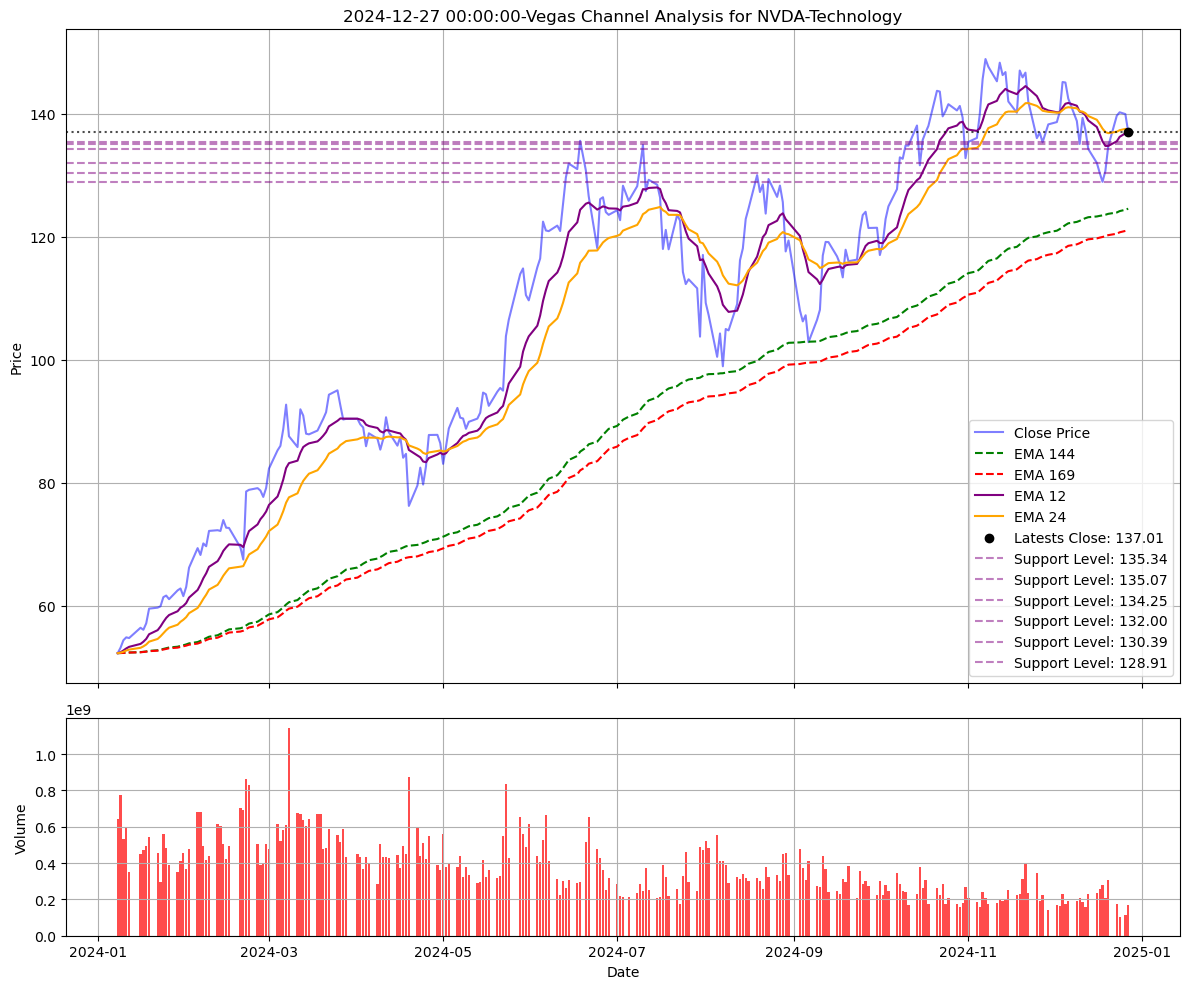

In [14]:
# Stock symbol and date range
symbol = 'NVDA'  # Example: Apple stock
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


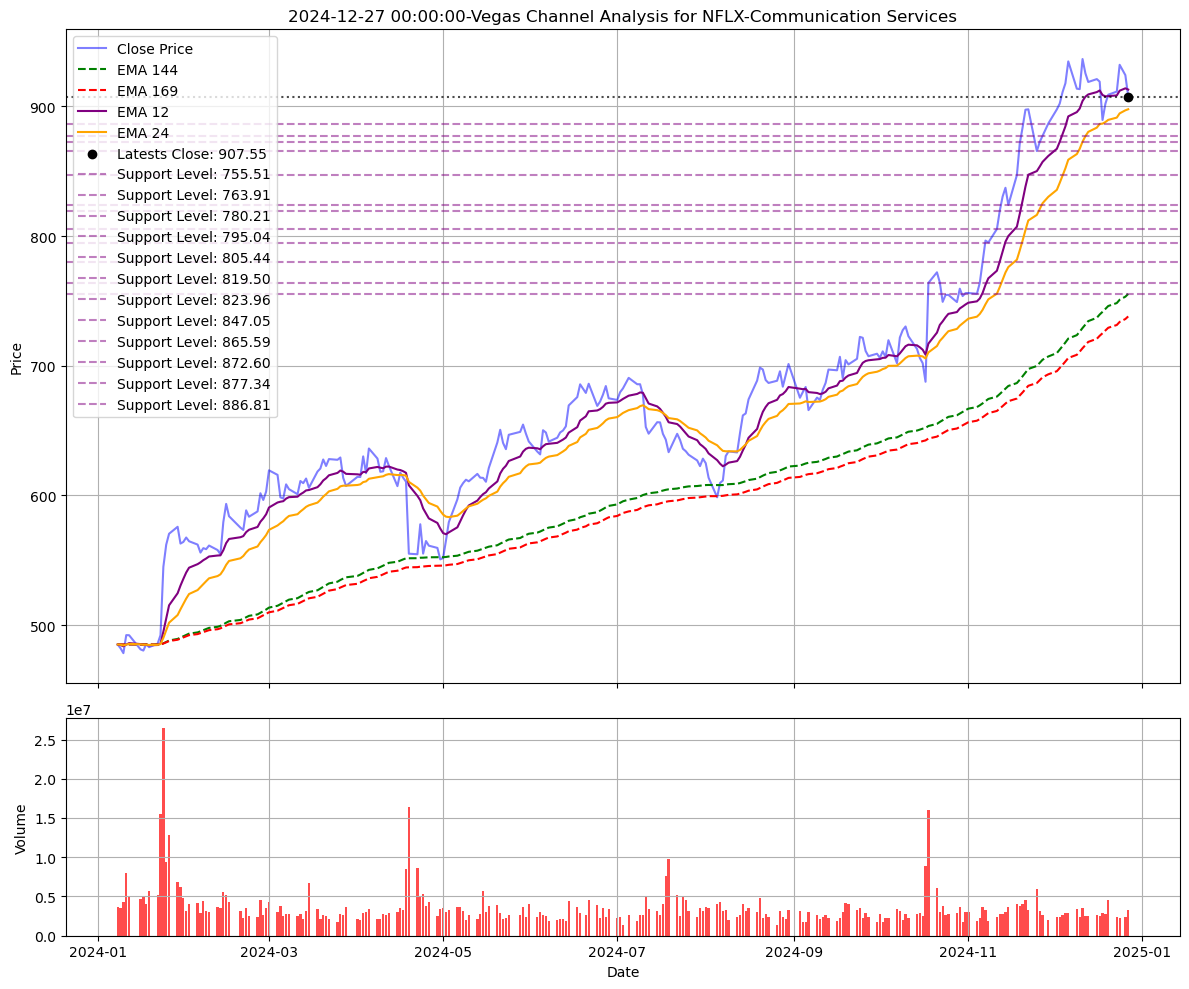

In [15]:
# Stock symbol and date range
symbol = 'NFLX'  # Netflix
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


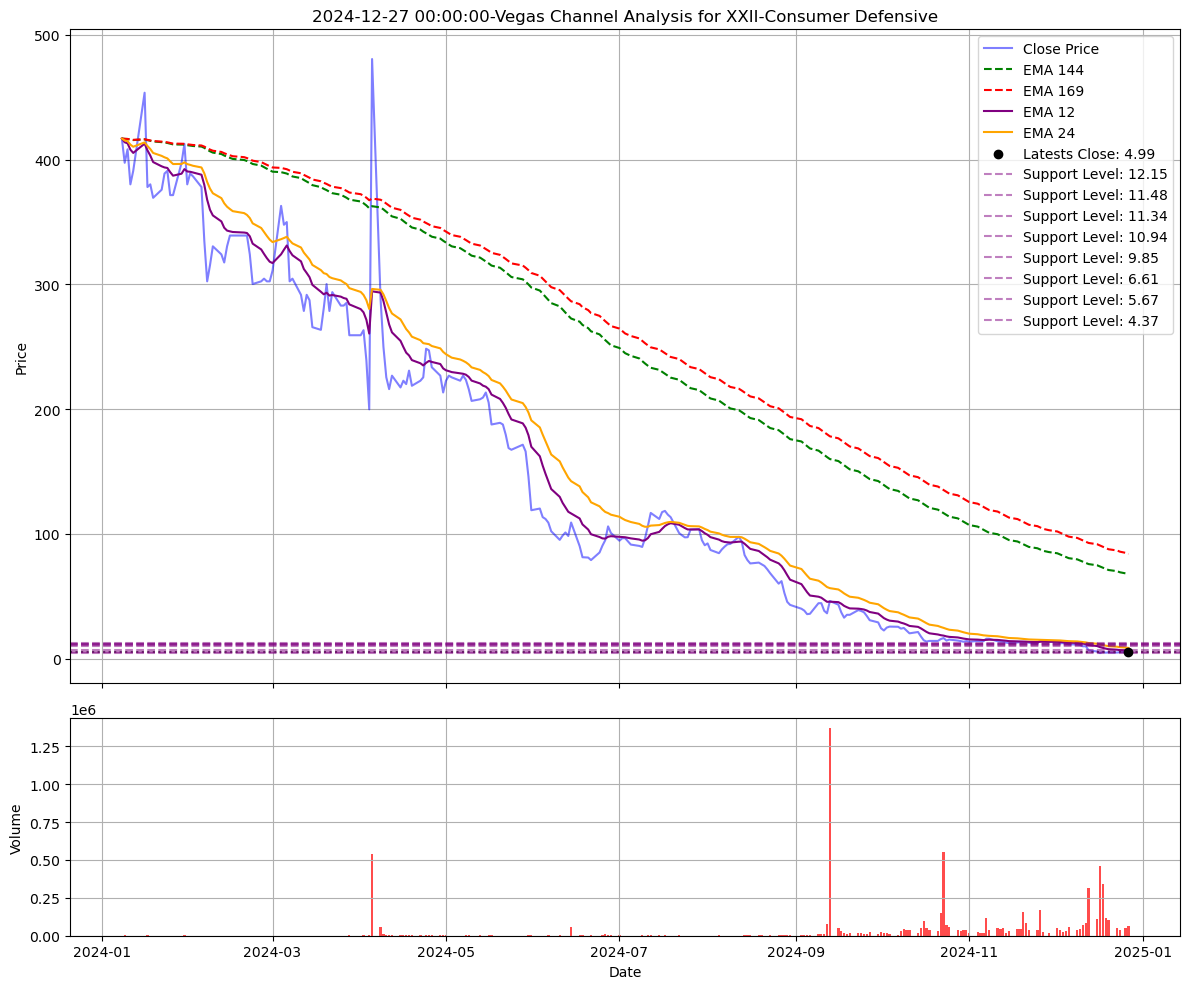

In [16]:
# Stock symbol and date range
symbol = 'XXII'  # Example: Apple stock
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


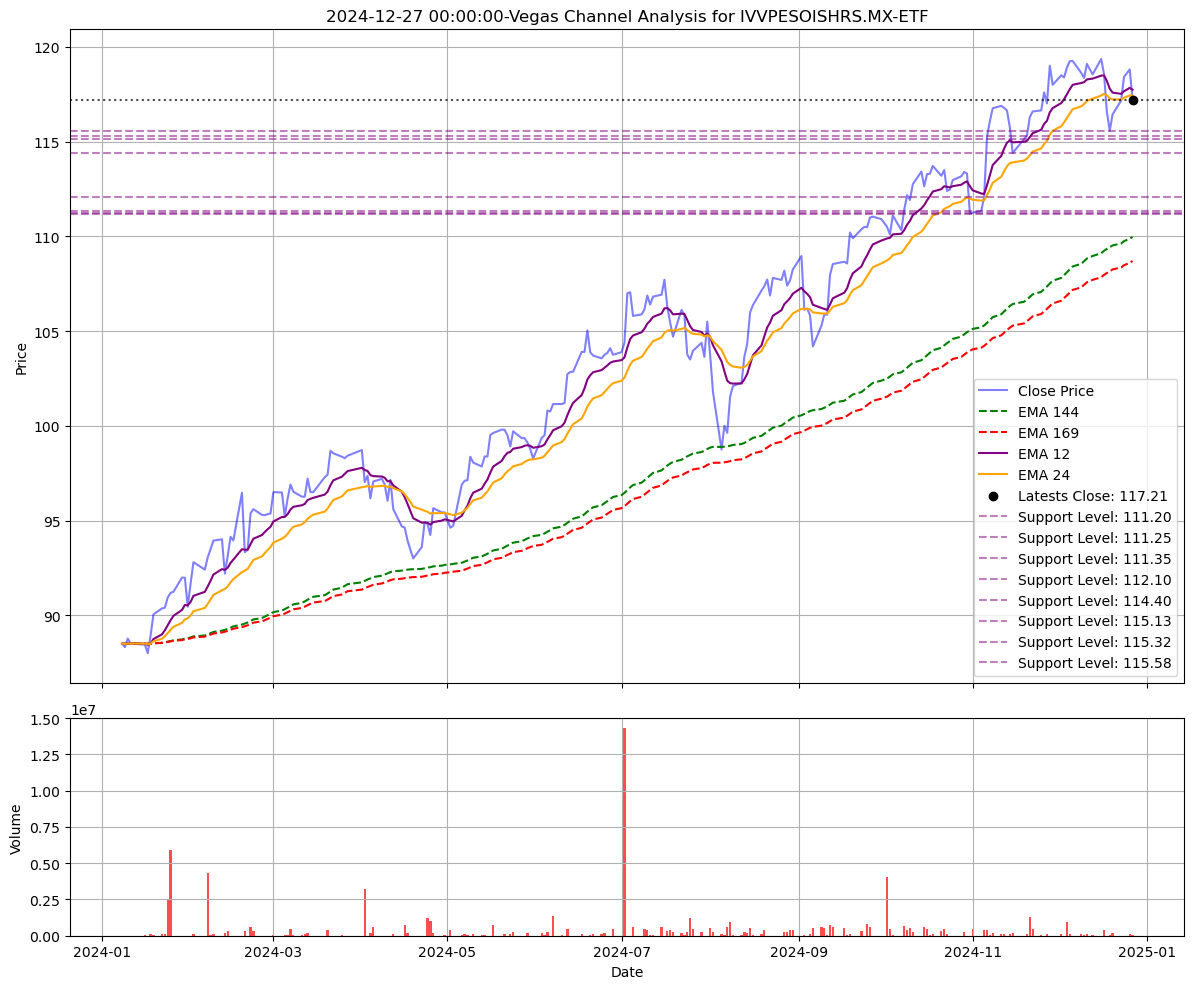

In [17]:
# Stock symbol and date range
symbol = 'IVVPESOISHRS.MX'  # IVVPESO ETF
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


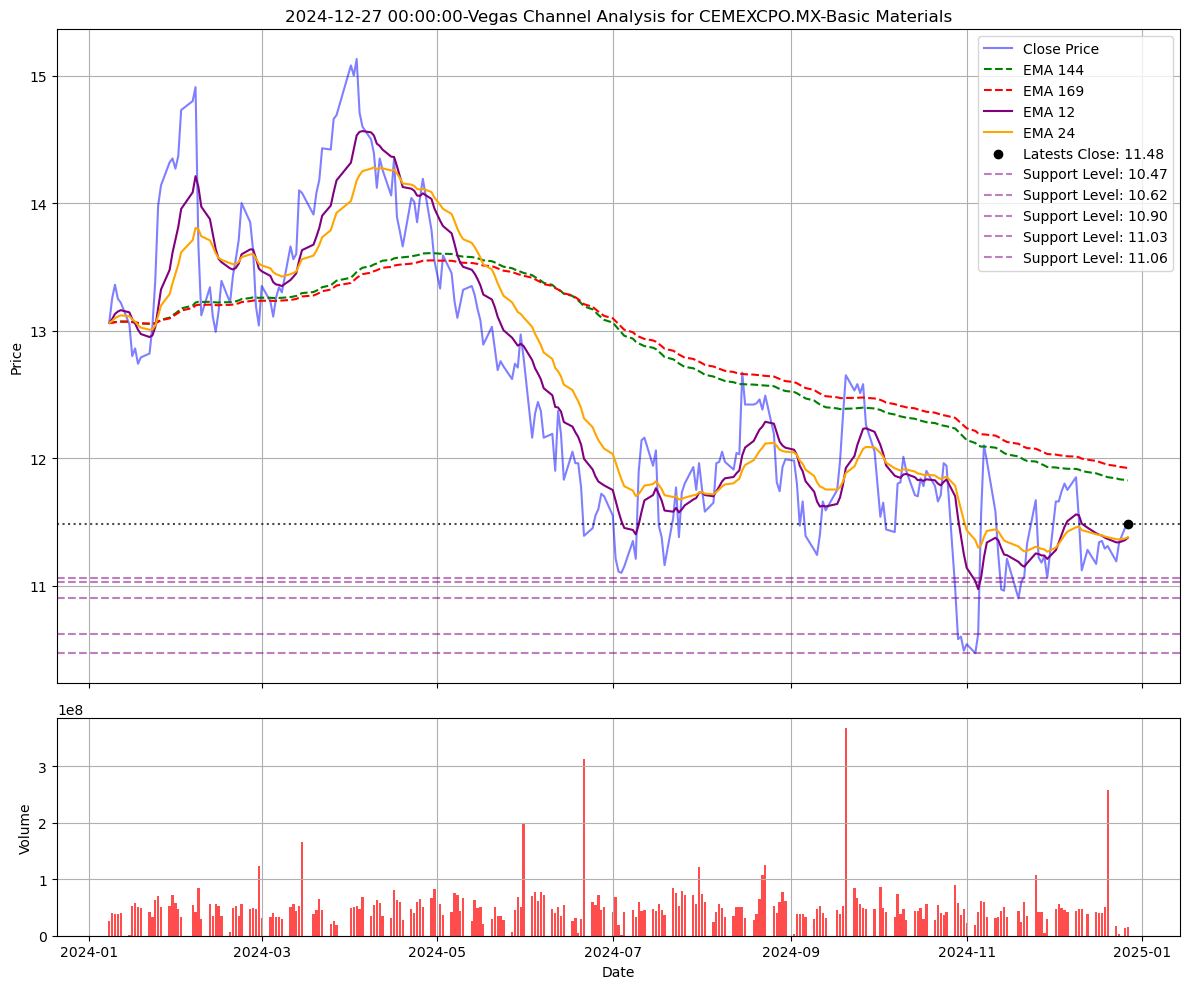

In [18]:
# Stock symbol and date range
symbol = 'CEMEXCPO.MX'  # Cemex
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


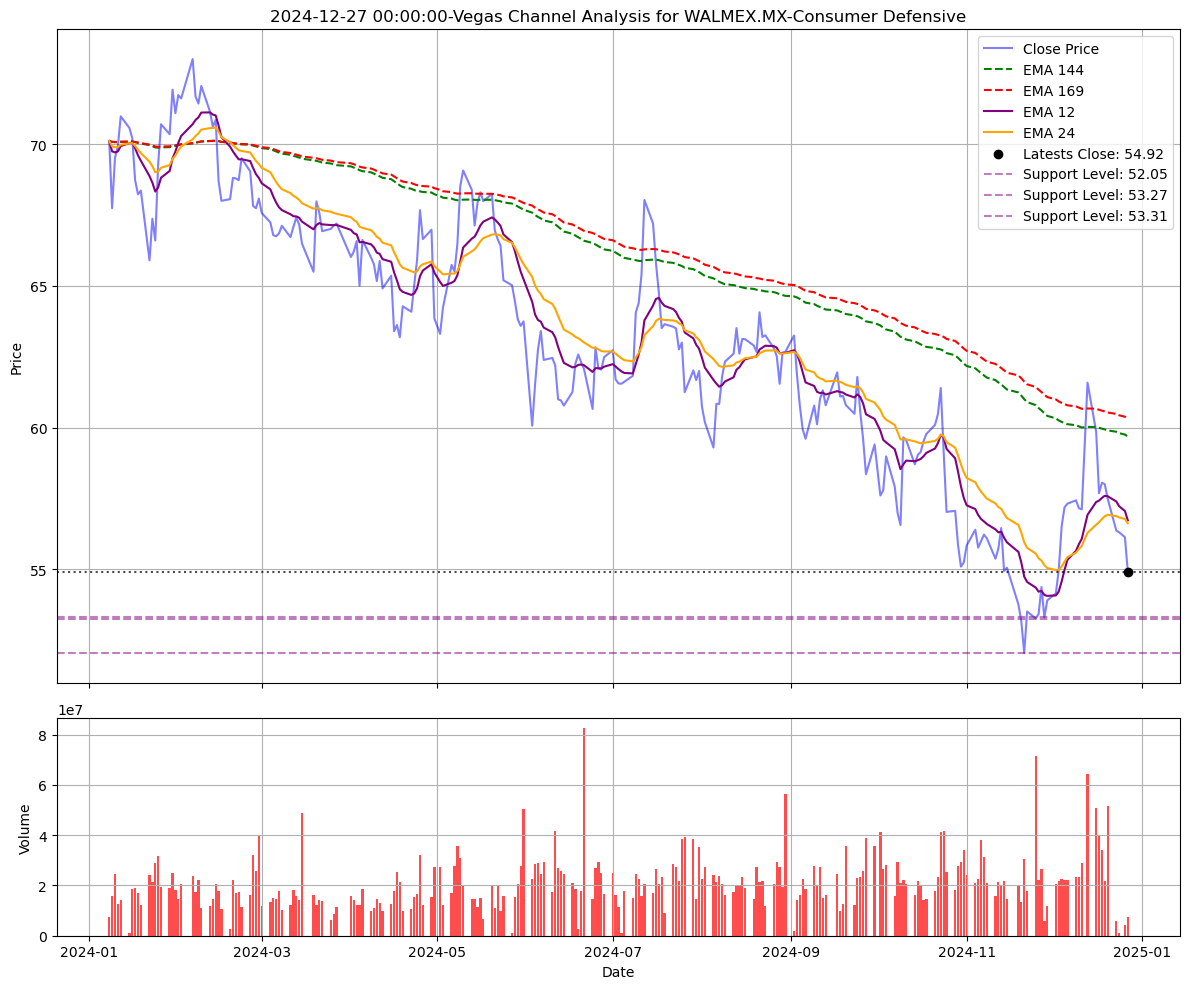

In [19]:
# Stock symbol and date range
symbol = 'WALMEX.MX'  # Walmart Mexico
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


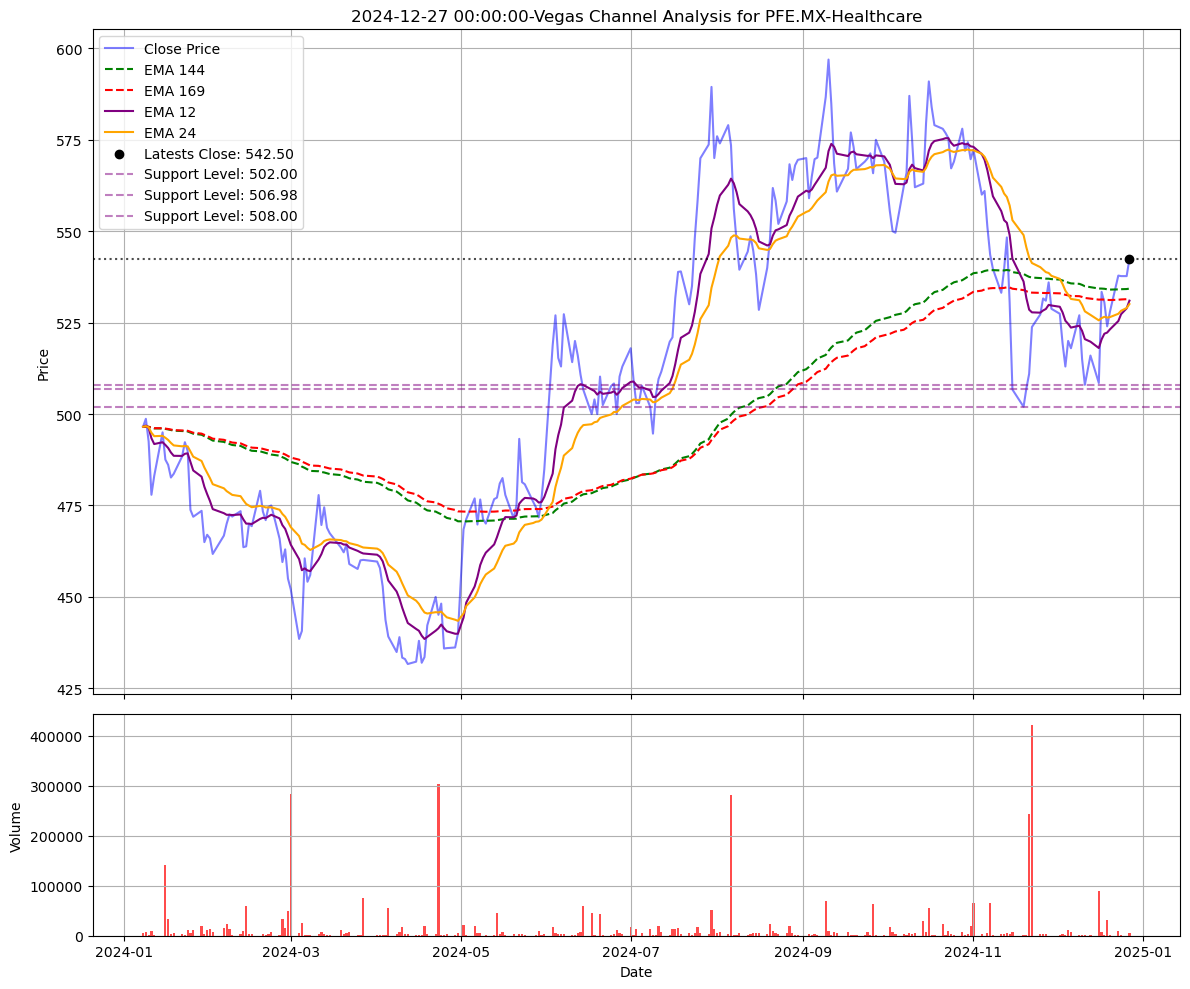

In [20]:
# Stock symbol and date range
symbol = 'PFE.MX'  # Pfizer
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()